## Prepare

In [1]:
import geopandas as gpd
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import folium

In [2]:
# Read in input data
input_data = gpd.read_file('data/street_view_coordinates_with_metadata.geojson')

# Read in image detection results
results_raw = pd.read_csv('data/results_concat.csv')

results_clean = results_raw
results_clean['filename'] = results_raw['filename'].str.replace('./drive/MyDrive/street_view_images_[a-z]{4,5}/', '', regex=True)

# Join data
results_data = input_data.merge(results_clean, on='filename', how='right')

## Evaluate model performance

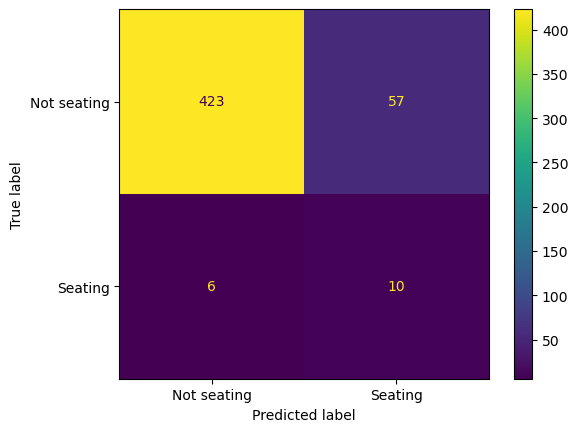

In [13]:
# Generate confusion matrix for predicted vs actual seating in image
y_actual = results_data['actual_value']
y_pred = results_data['predicted_result']

confusion_matrix = metrics.confusion_matrix(y_actual, y_pred)

# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Not seating', 'Seating'])

cm_display.plot()
plt.show()


The model's performance leaves much room for improvement. The confusion metrics, printed below, are quite poor, especially for precision. There is certainly a class imbalance in the dataset, with only 16 out of 496 test images (or 3%) containing any instances that the model should have recognized.

Improving image quality might be a fruitful avenue for improving model performance, as well as improving the model parameters directly so that true instances are recognized with more confidence and the recognition threshold can be raised accordingly to screen out any uncertain hits.

In [21]:
recall = np.round(metrics.recall_score(y_actual, y_pred), 3)
precision = np.round(metrics.precision_score(y_actual, y_pred), 3)
f1 = np.round(metrics.f1_score(y_actual, y_pred), 3)

print(f"The model's recall score was: {recall}")
print(f"The model's precision score was: {precision}")
print(f"The model's F1 score was: {f1}")

The model's recall score was: 0.625
The model's precision score was: 0.149
The model's F1 score was: 0.241


## Map model output data

Below, an interactive map is created of all coordinates where an image was tested (except for those where the model correctly did not detect seating).

The poor precision of the model is shown by the large number of false positive instances compared to true positives. Tha map does, however, contextualize the on-paper poor recall of the model by showing that images where the model yielded a false negative are often close by other points where the model yielded a true positive, usually a different viewing angle of the same group of benches. Therefore, the relatively poor recall performance is not practically as harmful as might seem at first glance.

In [30]:
results_data['point_type'] = pd.Series(None, index=results_data.index).case_when(
    [
        (results_data['predicted_result'] & results_data['actual_value'], 'True positive'),
        (results_data['predicted_result'] & ~results_data['actual_value'], 'False positive'),
        (~results_data['predicted_result'] & ~results_data['actual_value'], 'True negative'),
        (~results_data['predicted_result'] & results_data['actual_value'], 'False negative')
    ]
)
results_data['plot_geometry'] = gpd.points_from_xy(results_data['pano_lon'], results_data['pano_lat'], crs='EPSG:4326')

mapping_data = (results_data
                .set_geometry('plot_geometry')
                .query('point_type != "True negative"')
                [['direction', 'pano_lon', 'pano_lat', 'point_type', 'plot_geometry']]
                )

In [51]:
# Create a Folium map centered on the data
m = folium.Map(location=[mapping_data['pano_lat'].mean(), mapping_data['pano_lon'].mean()], 
               zoom_start=16,
               tiles = "CartoDB positron")

# Define a color mapping dictionary
color_map = {'True positive': 'green', 'False positive': 'purple', 'False negative': 'red'}

# Iterate through the GeoDataFrame and add markers with colors
for index, row in mapping_data.iterrows():
    category = row['point_type']
    color = color_map.get(category, 'black')  # Default to black if category not found
    folium.Marker(location=[row.plot_geometry.y, row.plot_geometry.x],
                  icon=folium.Icon(icon="chair", prefix='fa', color=color),
                  icon_color = 'white',
                  tooltip=row['point_type'],
                  ).add_to(m)
    
# Add a legend
legend_html = """
    <div style="position: fixed; 
                bottom: 80px; left: 60px; width: 180px; height: auto; 
                border:2px solid grey; z-index:9999; font-size:14px;
                background-color:white;
                ">
      &nbsp; <b>Detected seating</b> </br>
      &nbsp; <i style="background:{}; border-radius:50%; padding: 2px; margin-right:5px;">&nbsp;&nbsp;&nbsp;</i>True positive </br>
      &nbsp; <i style="background:{}; border-radius:50%; padding: 2px; margin-right:5px;">&nbsp;&nbsp;&nbsp;</i>False positive </br>
      &nbsp; <i style="background:{}; border-radius:50%; padding: 2px; margin-right:5px;">&nbsp;&nbsp;&nbsp;</i>False negative </br>
    </div>
    """.format(color_map['True positive'], color_map['False positive'], color_map['False negative'])
m.get_root().html.add_child(folium.Element(legend_html))

m